In [ ]:
from pathlib import Path

import autochem as ac
import automech
import automol
import more_itertools as mit
import numpy as np
from project_utilities import p_
from protomech import mess

T_range = (300, 1200)
T_vals = (600, 700, 800, 900, 1000, 1100, 1200)
P_vals = (0.1, 1, 10, 100)
T_drop = (300, 400)  # Drop low-T rates for fit
A_fill = 1e-20
compare = False

stoich = "C5H7"
clear_nodes = []
clear_edges = []

stoich = "C5H7O2"
clear_nodes = ["C5H6O(645)z+OH(4)", "CPND2(626)+OH(4)"]
clear_edges = [("S(1210)r0", "S(1209)r0"), ("S(1210)r1", "S(1209)r1")]

stoich = "C5H9"
clear_nodes = []
clear_edges = []

stoich = "C5H9O"
clear_nodes = []
clear_edges = []

stoich = "C5H9O2"
clear_nodes = []
clear_edges = [
    # Direct:
    ("S(722)r0", "S(728)e"),
    ("S(722)r1", "S(728)e"),
    # Well-skipping:
    ("C5H8O(833)+OH(4)", "C5H8O(829)rs+OH(4)")
]

stoich = "C5H11O"  # suspicious -- doesn't seem to compare well with theory
clear_nodes = []
clear_edges = []

stoich = "C5H11O2"
clear_nodes = []
clear_edges = []

tag = "Z_mess_v0"
root_path = Path("../..")
stoich_path = Path(stoich)

In [183]:
mech = automech.io.read(p_.stereo_mechanism(tag, "json", p_.data(root_path)))
mech.reactions = automech.reaction.select_pes(mech.reactions, stoich)
mech = automech.without_unused_species(mech)

In [184]:
mess_inp = stoich_path / "mess.inp"
surf = mess.surf.from_mess_input(mess_inp)

In [185]:
mess_out = stoich_path / "rate.out"
surf_out = mess.surf.with_mess_output_rates(surf, mess_out=mess_out)
surf_out = mess.surf.absorb_fake_nodes(surf_out)
surf_out = mess.surf.enforce_equal_enantiomer_rates(surf_out, tol=0.1)
mess.net.display(surf_out, mech=mech, height="1000px")

In [186]:
clear_node_keys = [
    mess.surf.node_key_from_label(surf_out, label) for label in clear_nodes
]
clear_edge_keys = [
    mess.surf.edge_key_from_labels(surf_out, labels) for labels in clear_edges
]

print(f"Clearing out rates for nodes {clear_node_keys}")
surf_out = mess.surf.clear_node_rates(surf_out, keys=clear_node_keys)

print(f"Clearing out rates for edges {clear_edge_keys}")
surf_out = mess.surf.clear_edge_rates(surf_out, keys=clear_edge_keys)

Clearing out rates for nodes []
Clearing out rates for edges []


In [187]:
unfit_skip_rate_keys = mess.surf.unfittable_rate_keys(surf_out, direct=False)
print(f"Dropping completely unfittable well-skipping rates:\n{unfit_skip_rate_keys}")

surf_out = mess.surf.remove_well_skipping_rates(surf_out, unfit_skip_rate_keys)

Dropping completely unfittable well-skipping rates:
[]


In [188]:
surf_out = mess.surf.remove_isolates(surf_out)
irrel_skip_rate_keys = mess.surf.irrelevant_rate_keys(
    surf_out, T=T_vals, P=P_vals, direct=False, min_branch_frac=0.01
)
print(f"Dropping irrelevant well-skipping rates:\n{irrel_skip_rate_keys}")

surf_out = mess.surf.remove_well_skipping_rates(surf_out, irrel_skip_rate_keys)

Dropping irrelevant well-skipping rates:
[]


/home/avcopan/proj/project-cyclopentane/code/protomech/src/protomech/mess/surf.py:1721: RuntimeWarning: invalid value encountered in divide
  z = np.abs((branch_frac - branch_frac.mean()) / branch_frac.std())


In [189]:
punfit_skip_rate_keys = mess.surf.partially_unfittable_pressure_independent_rate_keys(
    surf_out, T_vals=T_vals, direct=False
)
print(
    f"Dropping partially-unfittable pressure-independent well-skipping rates:\n{punfit_skip_rate_keys}"
)

surf_out = mess.surf.remove_well_skipping_rates(surf_out, punfit_skip_rate_keys)

Dropping partially-unfittable pressure-independent well-skipping rates:
[]


In [190]:
unfit_rate_keys = mess.surf.unfittable_rate_keys(surf_out, well_skipping=False)
print(f"Clearing completely unfittable direct rates:\n{unfit_rate_keys}")

surf_out = mess.surf.clear_rates(surf_out, unfit_rate_keys)

Clearing completely unfittable direct rates:
[]


In [191]:
punfit_rate_keys = mess.surf.partially_unfittable_pressure_independent_rate_keys(
    surf_out, T_vals=T_vals, well_skipping=False, empty=False
)
print(
    f"Clearing partially-unfittable pressure-independent direct rates:\n{punfit_rate_keys}"
)

surf_out = mess.surf.clear_rates(surf_out, punfit_rate_keys)

Clearing partially-unfittable pressure-independent direct rates:
[]


In [192]:
branch_frac_dct = mess.surf.branching_fractions(surf_out, T=T_vals, P=P_vals)

In [193]:
print("Matching rates to reaction directions.")
surf_out = mess.surf.match_rate_directions(surf_out, mech)

Matching rates to reaction directions.


In [194]:
print("Clearing unfittable pressures.")
surf_out = mess.surf.clear_unfittable_pressures(surf_out)

Clearing unfittable pressures.


In [195]:
surf_out = mess.surf.fit_rates(surf_out, T_drop=T_drop, A_fill=A_fill)

Direct rates:
(2, 3) CPT(563) + HO2(8) = C5H9(553) + H2O2(10)


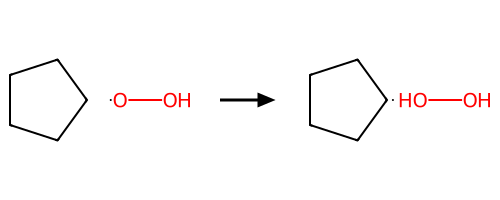

alt.LayerChart(...)

Median branching fraction: 1.0
[[1. 1. 1. 1.]
 [1. 1. 1. 1.]
 [1. 1. 1. 1.]
 [1. 1. 1. 1.]
 [1. 1. 1. 1.]
 [1. 1. 1. 1.]
 [1. 1. 1. 1.]]



In [196]:
label_dct = mess.surf.node_label_dict(surf_out)
obj_col = automech.util.df_.c_.temp()

print("Direct rates:")
for rate_key in mess.surf.rate_keys(
    surf_out, P_vals=[1.0], empty=False, well_skipping=False
):
    eq = mess.surf.edge_chemkin_equation(surf_out, rate_key)
    print(rate_key, eq)

    rate = surf_out.rates[rate_key]
    rate_fit = surf_out.rate_fits[rate_key]

    amchis = list(mit.unique_everseen(automech.reaction_amchis(mech, eq=eq)))
    for amchi in amchis:
        automol.amchi.display_reaction(*amchi)

    ref_rates = ref_labels = []
    if compare and amchis:
        ref_rates = [r.rate for r in automech.reaction_rate_objects(mech, eq)]
        ref_labels = [f"Ref {i}" for i, _ in enumerate(ref_rates)]

    display(
        ac.rate.data.display(
            [rate, rate_fit, *ref_rates],
            T_range=T_range,
            label=["Data", "Fit", *ref_labels],
            check_order=False,
        )
    )

    branch_frac_arr = branch_frac_dct[rate_key]
    branch_frac = np.nanmedian(branch_frac_arr)
    print(f"Median branching fraction: {branch_frac}")
    print(branch_frac_arr)
    print()

In [197]:
print("Well-skipping rates:")
for rate_key in mess.surf.rate_keys(surf_out, direct=False):
    print(rate_key)
    rate = surf_out.rates[rate_key]
    rate_fit = surf_out.rate_fits[rate_key]
    display(
        ac.rate.data.display([rate, rate_fit], T_range=T_range, label=["Data", "Fit"])
    )

    branch_frac_arr = branch_frac_dct[rate_key]
    branch_frac = np.nanmedian(branch_frac_arr)
    print(f"Median branching fraction: {branch_frac}")
    print(branch_frac_arr)
    print()

Well-skipping rates:
